In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [2]:
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])

display(house_df.shape)
display(house_df.head())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281,1,1824,1824.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202,1,1826,1824.0,1,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272,1,1828,1824.0,2,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868,0,1830,1860.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280,1,1830,1824.0,3,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375


In [4]:
#house_df2=house_df.set_index(['year', 'state', 'district', 'name']).dropna().copy()
#house_df2=house_df.dropna().copy()
#house_df2_districts=house_df2[['state','district']]
#house_df2=house_df2.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1)
#house_df2['party']=house_df2['party'].replace(['D', 'R'], [0, 1])
#house_df2['president_party']=house_df2['president_party'].replace(['D', 'R'], [0, 1])
#house_df2['last_house_majority']=house_df2['last_house_majority'].replace(['D', 'R'], [0, 1])
#data_train, data_test=house_df2[house_df2['year']!=2018], house_df2[house_df2['year']==2018]

#x_train, y_train=data_train.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_train['won']
#x_test, y_test=data_test.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_test['won']
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts

In [69]:
def modelPredictions(model, x_train, x_test, y_train, y_test, indexed_districts):
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_train)[:,1]
    y_pred_test=model.predict_proba(x_test)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_train.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_test.index, columns=['abs_won_proba'])

    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_train[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_test[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    #display(out_df[(out_df['state']=='Louisiana')&(out_df['district']=='District 3')]) #&(out_df['year']==2018)])
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    #display(districtWinners[districtWinners['won_pred']!=1])
    NotJustOneWinner=len(districtWinners[districtWinners['won_pred']!=1])
    assert NotJustOneWinner == 0, "{} districts have no winner or more than one winner".format(NotJustOneWinner)
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    #Accu_val_2=sum(out_df['won_pred']==y_test)/len(out_df)
    
    #display(out_df.head())
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [43]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1)
    #display(out_df[out_df['partisanship'].isna()])
    return out_df.fillna(0)

In [48]:
def preprocess(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #first_time_elected relative to election year and non-negative
    df_out['first_time_elected']=df_out['year']-df_out['first_time_elected']
    df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True)

    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #drop year
    df_out=df_out.drop('year', axis=1)
    
    return df_out

In [64]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts

In [50]:
#one shot prediction
model=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)

#split dataset
year=2018
x_train, y_train, x_test, y_test, house_df_districts = splitDf(house_df, year)

#preprocess
x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
x_test_preprocess=preprocess(x_train, y_train, house_df_districts, x_test)

#fit model
#display(x_train_preprocess.head())
fitted_model=model.fit(x_train_preprocess, y_train)

#generate predictions and calculate accuracy
Accu_train, Accu_val, Accu_val_2, pred_df = modelPredictions(fitted_model, x_train_preprocess, x_test_preprocess, y_train, y_test, house_df_districts)

#print accuracy scores
print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

#print how many republican, how many democrat districts
DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

#print uncertainties
display(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])

,state,district,won_pred


Training accuracy: 97.38%
Validation accuracy: 97.02%
Mutually exclusive validation accuracy: 99.52%

N. Democrat districts: 228
N. Republican districts: 207


,state,district,party,abs_won_proba,won_pred,rel_won_proba
9164,Utah,District 4,0.0,0.965490,1.0,0.500142
9171,Utah,District 4,1.0,0.964941,0.0,0.499858
9175,Texas,District 32,1.0,0.963302,0.0,0.499428
9194,Texas,District 32,0.0,0.965509,1.0,0.500572
9232,Virginia,District 7,0.0,0.965494,1.0,0.500139
9256,Virginia,District 7,1.0,0.964956,0.0,0.499861
9268,Virginia,District 10,1.0,0.964953,0.0,0.499856
9269,Virginia,District 10,0.0,0.965509,1.0,0.500144
9301,Texas,District 7,0.0,0.965533,1.0,0.500576
9305,Texas,District 7,1.0,0.963310,0.0,0.499424


In [66]:
#test set on 2018 data, train set on previous dat
train_data, test_data = house_df[house_df['year']!=2018], house_df[house_df['year']==2018]

In [79]:
modelList=[
    {'name':'Logistic Regression CV=5', 
     'model':LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
    },
    {'name':'Logistic Regression 2 CV=5', 
     'model':LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
    },
]

In [80]:
for i in range(len(modelList)):
    model=modelList[i]
    #model=dict()
    #model['model']=modelType
    years=[2014,2012,2008,2004]
    #list with training accuracy
    train_acc=[]
    #list with validation accuracy
    val_acc=[]
    #list with mutually exclusive validation accuracy
    val_acc_2=[]
    #list with uncertainties
    n_uncertain=[]

    for year in years:
        print('model: {}'.format(model['name']))
        print('year: {}'.format(year))
        #split dataset
        x_train, y_train, x_val, y_val, house_df_districts = splitDf(train_data, year)

        #preprocess
        x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
        x_val_preprocess=preprocess(x_train, y_train, house_df_districts, x_val)

        #fit model
        #display(x_train_preprocess.head())
        fitted_model=model['model'].fit(x_train_preprocess, y_train)

        #generate predictions and calculate accuracy
        Accu_train, Accu_val, Accu_val_2, pred_df = modelPredictions(fitted_model, x_train_preprocess, x_val_preprocess, y_train, y_val, house_df_districts)

        #store accuracy
        train_acc.append(Accu_train)
        val_acc.append(Accu_val)
        val_acc_2.append(Accu_val_2)

        #print accuracy scores
        print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}'.format(Accu_train, Accu_val, Accu_val_2))

        #print how many republican, how many democrat districts
        DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
        REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
        print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

        #print uncertainties
        uncertainties=pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)]
        n_uncertainties=len(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])
        n_uncertain.append(n_uncertainties)
        print('Uncertainties: {}\n'.format(n_uncertainties))
    modelList[i]['score train']=np.mean(train_acc)
    modelList[i]['score validation']=np.mean(val_acc)
    modelList[i]['score val mut exclusive']=np.mean(val_acc_2)


model: Logistic Regression CV=5
year: 2014
Training accuracy: 97.30%
Validation accuracy: 98.25%
Mutually exclusive validation accuracy: 99.75%
N. Democrat districts: 187
N. Republican districts: 243
Uncertainties: 28

model: Logistic Regression CV=5
year: 2012
Training accuracy: 97.23%
Validation accuracy: 98.92%
Mutually exclusive validation accuracy: 99.52%
N. Democrat districts: 198
N. Republican districts: 232
Uncertainties: 18

model: Logistic Regression CV=5
year: 2008
Training accuracy: 97.48%
Validation accuracy: 95.94%
Mutually exclusive validation accuracy: 93.51%
N. Democrat districts: 148
N. Republican districts: 117
Uncertainties: 40

model: Logistic Regression CV=5
year: 2004
Training accuracy: 97.29%
Validation accuracy: 98.97%
Mutually exclusive validation accuracy: 99.18%
N. Democrat districts: 125
N. Republican districts: 136
Uncertainties: 10

model: Logistic Regression 2 CV=5
year: 2014
Training accuracy: 97.30%
Validation accuracy: 98.25%
Mutually exclusive valida

In [81]:
modelList

[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.9732536219805614,
  'score validation': 0.9802034144820433,
  'score val mut exclusive': 0.979886836869476},
 {'name': 'Logistic Regression 2 CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.9732536219805614,
  'score validation': 0.9802034144820433,
  'score val mut exclusive': 0.979886836869476}]

In [37]:
house_df[(house_df['state']=='Louisiana')&(house_df['district']=='District 3')&(house_df['year']==2018)]
#house_df.iloc[[9600, 9801, 9813, 9904], :] #9600, 9801, 9813, 9904

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
9560,District 3,0.0,Larry Rader,D,3.9,Louisiana,9692,0,2018,0.0,0,3.7,0.0,1.0,R,0.395,194.0,241.0,R,1.301592e+06
9561,District 3,0.0,Rob Anderson,D,5.5,Louisiana,13477,0,2018,0.0,0,3.7,0.0,1.0,R,0.395,194.0,241.0,R,1.301592e+06
9562,District 3,0.0,Josh Guillory,R,12.8,Louisiana,31387,0,2018,0.0,0,3.7,0.0,1.0,R,0.395,194.0,241.0,R,2.318110e+05
9563,District 3,0.0,"Mildred ""Mimi"" Methvin",D,17.8,Louisiana,43727,0,2018,0.0,0,3.7,0.0,1.0,R,0.395,194.0,241.0,R,1.301592e+06
9564,District 3,1.0,Clay Higgins,R,55.7,Louisiana,136871,1,2018,2016.0,1,3.7,0.0,1.0,R,0.395,194.0,241.0,R,7.233947e+05
9566,District 3,0.0,Verone Thomas,D,3.2,Louisiana,7814,0,2018,0.0,0,3.7,0.0,1.0,R,0.395,194.0,241.0,R,1.301592e+06


(array([380.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 460.]),
 array([3.30403100e-05, 9.62975392e-02, 1.92562038e-01, 2.88826537e-01,
        3.85091036e-01, 4.81355535e-01, 5.77620034e-01, 6.73884533e-01,
        7.70149032e-01, 8.66413531e-01, 9.62678029e-01]),
 <a list of 10 Patch objects>)

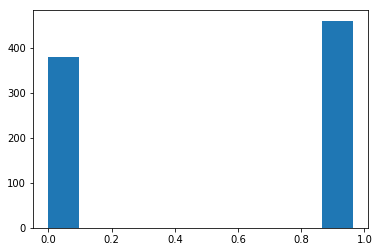

In [194]:
plt.hist(pred_df['abs_won_proba'])

(array([380.,   0.,   0.,   0.,  25.,  25.,   0.,   0.,   0., 410.]),
 array([3.48746356e-05, 1.00031387e-01, 2.00027900e-01, 3.00024412e-01,
        4.00020925e-01, 5.00017437e-01, 6.00013950e-01, 7.00010462e-01,
        8.00006975e-01, 9.00003487e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

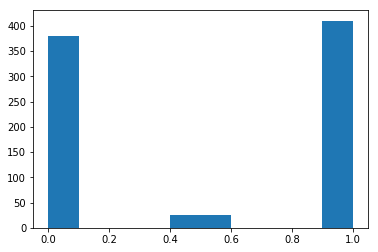

In [195]:
plt.hist(pred_df['rel_won_proba'])